#### Using ARIMA to develop a price predicting model

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [63]:
apple_stock = yf.download("AAPL", start= '2015-01-01' , end= '2023-12-31')
apple_stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373964,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687307,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689539,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021721,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944683,237458000


In [64]:
stock_prices = apple_stock['Close']
stock_prices.head()

Date
2015-01-02    27.332500
2015-01-05    26.562500
2015-01-06    26.565001
2015-01-07    26.937500
2015-01-08    27.972500
Name: Close, dtype: float64

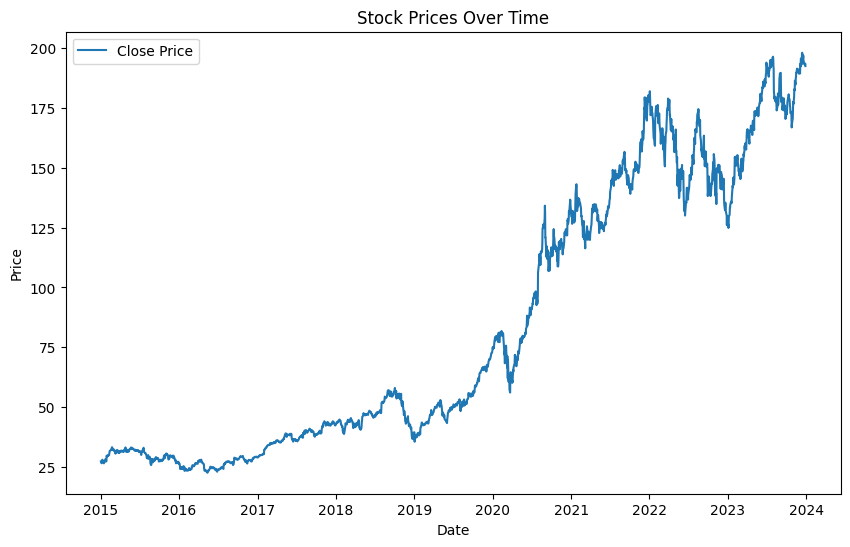

In [65]:
plt.figure(figsize=(10,6))
plt.plot(stock_prices, label = 'Close Price')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

For ARIMA, the data needs to be stationary. So using the Augmented Dickey-Fuller test (ADF test) to check for stationarity.

In [66]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
adf_test(stock_prices)


ADF Statistic: 0.1914154990195427
p-value: 0.9717759844359734


If the p-value is > 0.05, the data is non-stationary and should be differenced.
since p-value is 0.9 this data needs differencing.

#### Finding optimal ARIMA parameters
- p: Number of lag observations (AR term)
- d: Number of times the series needs to be differenced to make it stationary (I term)
- q: Size of moving average window (MA term)

In [67]:
stock_prices_diff = stock_prices.diff().dropna()

adf_test(stock_prices_diff)

ADF Statistic: -10.90763959837019
p-value: 1.1175947834577035e-19


Got p-value nearly 0 after differenciating it once so d = 1

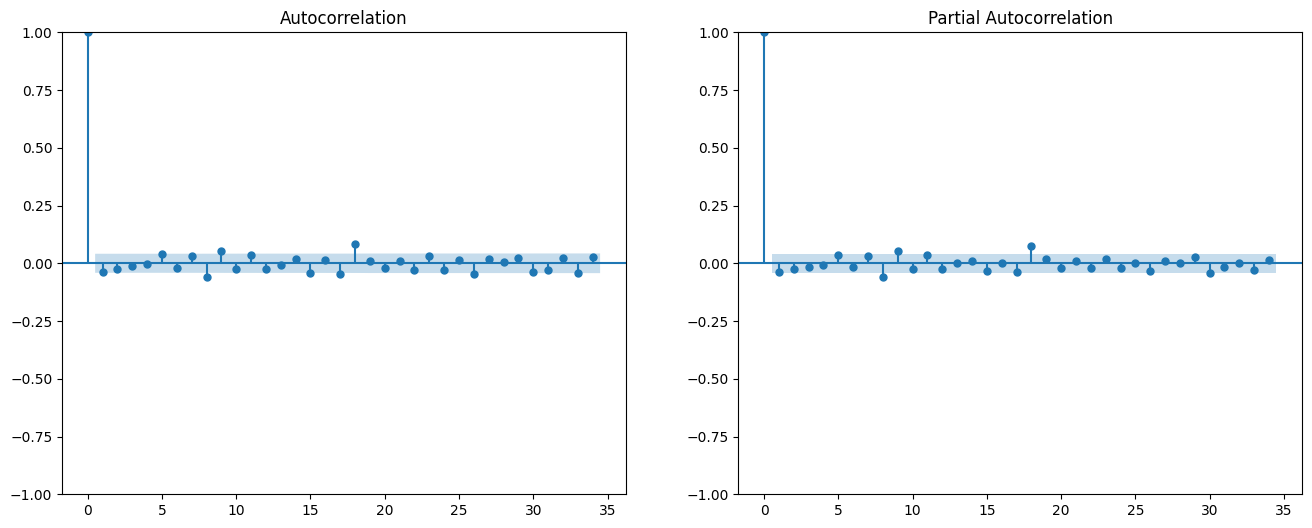

In [68]:
fig, axes = plt.subplots(1,2,figsize= (16,6))
plot_acf(stock_prices_diff, ax = axes[0])
plot_pacf(stock_prices_diff, ax = axes[1])
plt.show()

can see that both acf and pacf shows a strong spike at lag 1 and then quickly falls to 0 , which suggests that MA(1) and AR(1) would be appropriate.

In [69]:
model = SARIMAX(stock_prices,order= (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

c:\Study material\projects\venv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Study material\projects\venv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2264
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4576.107
Date:                            Sun, 20 Oct 2024   AIC                           9162.214
Time:                                    13:31:58   BIC                           9190.810
Sample:                                         0   HQIC                          9172.651
                                           - 2264                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4359      0.234      1.866      0.062      -0.022       0.894
ma.L1         -0.4761      0.230   

Making predictions and visualizing the results

2264    192.810271
2265    192.825959
2266    192.766266
2267    193.048614
2268    193.027723
           ...    
2459    207.171738
2460    207.171954
2461    207.129247
2462    207.132568
2463    207.366847
Name: predicted_mean, Length: 200, dtype: float64


c:\Study material\projects\venv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Study material\projects\venv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


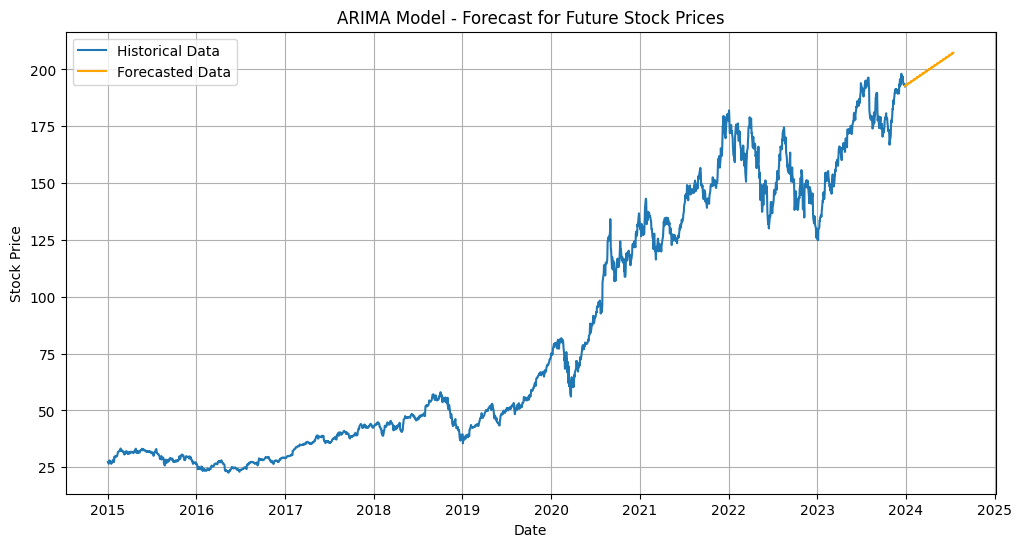

In [70]:
# Forecasting for the next 200 days
forecast = model_fit.forecast(steps=200)
print(forecast)

# Plot the forecasted values
plt.figure(figsize=(12,6))
plt.plot(stock_prices, label='Historical Data')
plt.plot(pd.date_range(stock_prices.index[-1], periods=200, freq='D'), 
         forecast, label='Forecasted Data', color='orange')
plt.title('ARIMA Model - Forecast for Future Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


Evaluating model performance using Mean Squared Error or Mean Absolute Error

In [71]:
# Predictions for train/test split evaluation
train_size = int(len(stock_prices) * 0.8)
train, test = stock_prices[:train_size], stock_prices[train_size:]

# Predict
predictions = model_fit.forecast(steps=len(test))

# Evaluate performance
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2328.511906919635


c:\Study material\projects\venv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Combining all the plots together

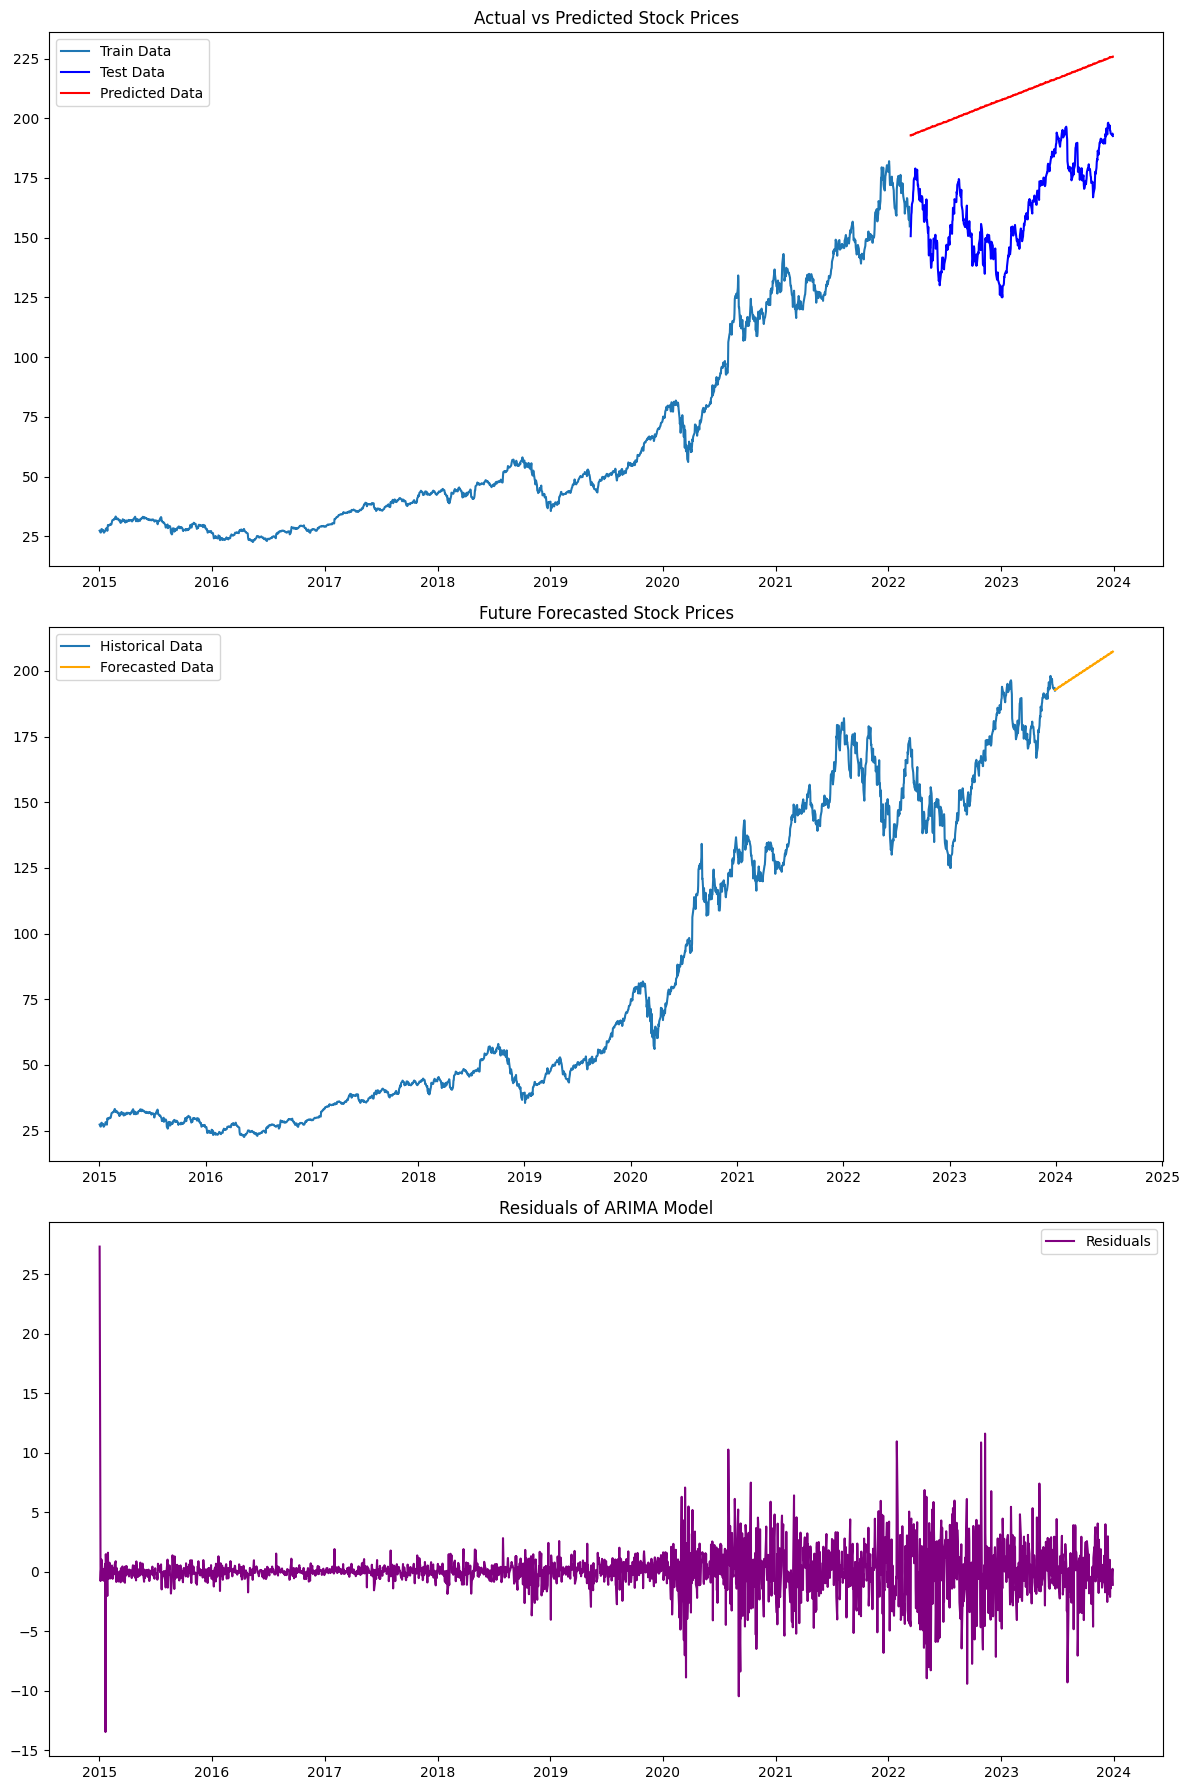

In [72]:
# Combine residuals, actual vs predicted, and forecasts into one visualization sequence

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot 1: Actual vs Predicted
ax[0].plot(train, label='Train Data')
ax[0].plot(test, label='Test Data', color='blue')
ax[0].plot(test.index, predictions, label='Predicted Data', color='red')
ax[0].set_title('Actual vs Predicted Stock Prices')
ax[0].legend()

# Plot 2: Forecast Future Prices
ax[1].plot(stock_prices, label='Historical Data')
ax[1].plot(pd.date_range(stock_prices.index[-1], periods=forecast_steps, freq='D'), 
           forecast, label='Forecasted Data', color='orange')
ax[1].set_title('Future Forecasted Stock Prices')
ax[1].legend()

# Plot 3: Residuals
ax[2].plot(residuals, label='Residuals', color='purple')
ax[2].set_title('Residuals of ARIMA Model')
ax[2].legend()

plt.tight_layout()
plt.show()
